In [1]:
import subprocess
logger = subprocess.Popen(
    'nvidia-smi --query-gpu=timestamp,name,memory.free,memory.used,power.draw --format=csv -l 1 > gpu_log.csv'
    , shell=True)
sdxl = subprocess.Popen('python3 sdxl.py', shell=True)
whisper = subprocess.Popen('python3 whisper.py', shell=True)

/home/server/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-04-13 10:10:18.142883: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 10:10:18.142927: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 10:10:18.142968: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/server/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils

In [5]:
whisper

<Popen: returncode: None args: 'python3 whisper.py'>

In [2]:
logger.terminate()

In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('gpu_log.csv')
t = pd.to_datetime(data['timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
δt = (np.diff(t)/1e9).astype("float")
P = np.array(data[' power.draw [W]'][:-1].str.replace(' W', '')).astype(float)
E = np.sum(δt*P)
print(E, "Joules")

69035.87 Joules


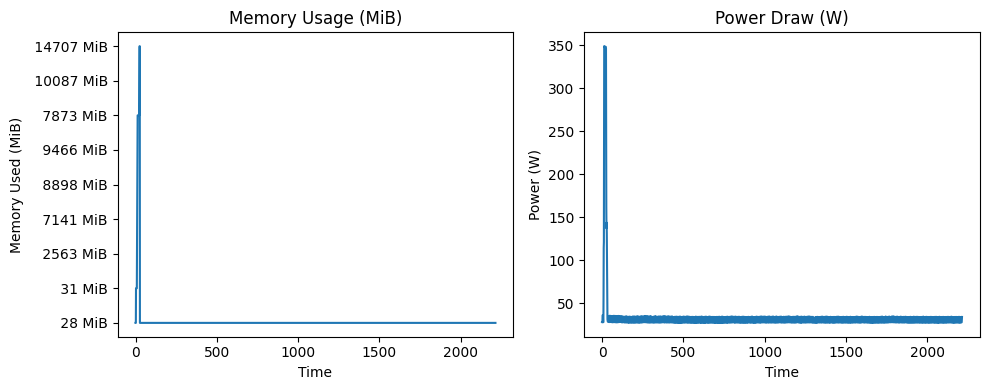

In [4]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Adjust size as needed
ax1.plot(data[' memory.used [MiB]'])
ax1.set_title('Memory Usage (MiB)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Memory Used (MiB)')
ax2.plot(P)
ax2.set_title('Power Draw (W)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Power (W)')
plt.tight_layout()
plt.show()